In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/california-housing-prices/housing.csv


In [2]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Setting Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

# Read the data
data = pd.read_csv('../input/california-housing-prices/housing.csv')
num_rows = data.shape[0]

# count the number of rows with missing values
num_missing = data.isnull().sum(axis=1).sum()
percent_of_rows_missing = round(((num_missing/num_rows)*100), 2)

# print the result
print(f"There are {num_missing} rows with missing values")
print(f"{percent_of_rows_missing} % of the rows are missing values")
data.head()

There are 207 rows with missing values
1.0 % of the rows are missing values


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
from sklearn.model_selection import train_test_split


X = data.copy().dropna() # only 1% of rows are missing values so we will just drop them
y = X.pop('median_house_value')

features_num = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
               'total_bedrooms','population', 'households','median_income']

features_cat = ['ocean_proximity']

# Chose Ordinal Encoding since the categories are roughly ordered
print(data['ocean_proximity'].unique())
order_of_ocean_proximity = ['ISLAND','NEAR OCEAN','NEAR BAY','<1H OCEAN','INLAND']

preprocessor = make_column_transformer(
(StandardScaler(), features_num),
(OrdinalEncoder(categories = [order_of_ocean_proximity]), features_cat),
)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print(f"Input Shape: {input_shape}")
print(X_train[0])


['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']
Input Shape: [9]
[ 0.71651499 -0.87261308  1.21379153 -0.49660093 -0.17859959 -0.67771788
 -0.24656235  0.1982398   1.        ]


In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
min_delta = 5,
patience = 5,
restore_best_weights = True)

Epoch 1/100
256/256 [==============================] - 7s 15ms/step - loss: 2064.0164 - mae: 2064.0164 - val_loss: 2036.6819 - val_mae: 2036.6819
Epoch 2/100
256/256 [==============================] - 3s 13ms/step - loss: 2020.5293 - mae: 2020.5293 - val_loss: 1970.7361 - val_mae: 1970.7361
Epoch 3/100
256/256 [==============================] - 4s 14ms/step - loss: 1934.2566 - mae: 1934.2566 - val_loss: 1901.3235 - val_mae: 1901.3235
Epoch 4/100
256/256 [==============================] - 3s 14ms/step - loss: 1808.8149 - mae: 1808.8149 - val_loss: 1647.1353 - val_mae: 1647.1353
Epoch 5/100
256/256 [==============================] - 3s 14ms/step - loss: 1647.4177 - mae: 1647.4177 - val_loss: 1512.3599 - val_mae: 1512.3599
Epoch 6/100
256/256 [==============================] - 3s 13ms/step - loss: 1453.6063 - mae: 1453.6063 - val_loss: 1314.1753 - val_mae: 1314.1753
Epoch 7/100
256/256 [==============================] - 3s 13ms/step - loss: 1230.6261 - mae: 1230.6261 - val_loss: 1078.1328

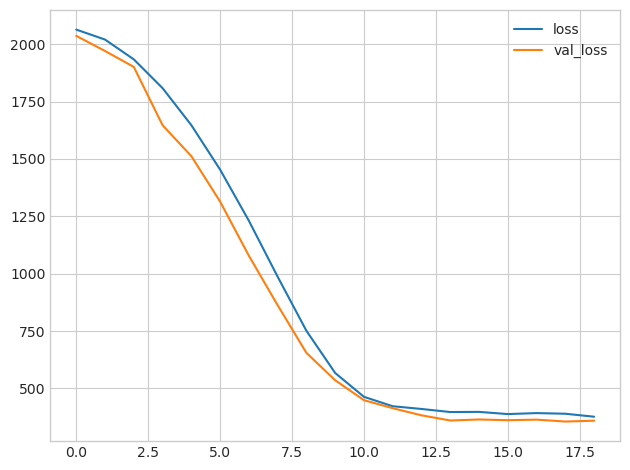

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import elu

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    
    layers.Dense(512, activation ='relu'),
#     layers.Dropout(rate = 0.1),
    layers.BatchNormalization(),
    
    layers.Dense(512, activation ='relu'),
#     layers.Dropout(rate = 0.1),
    layers.BatchNormalization(),
    
    layers.Dense(512, activation ='relu'),
#     layers.Dropout(rate = 0.1),
    layers.BatchNormalization(),
    
    layers.Dense(512, activation = 'relu'),
#     layers.Dropout(rate = 0.1),
    layers.BatchNormalization(),
    
    layers.Dense(1)
    
])

my_optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)

model.compile(
    optimizer = my_optimizer,
    loss = 'mae',
    metrics = ['mae'],

)

EPOCHS = 100

history = model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    batch_size = 64,
    epochs = EPOCHS,
    verbose = 1,
    callbacks = [early_stopping]
)

history_dataframe = pd.DataFrame(history.history)
history_dataframe.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_dataframe['val_loss'].min()))